![Instituto Politécnico de Leiria](https://www.ipleiria.pt/wp-content/webpc-passthru.php?src=https://www.ipleiria.pt/wp-content/uploads/2021/10/estg_h-01.png&nocache=1)

<center>

# AI Driving Classification  <span style="font-size: 14px;">2023/2024</span>

<div align="center" style="font-weight: bold">Team Members:</div>

<div align="center">Alberto Manuel de Matos Pingo - 2202145</div>

<div align="center">João Pedro Quintela de Castro - 2201781</div>

---

## **First Approach - Bidirectional LSTM**

</center>

---

## Libraries

In [21]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout,Conv1D,Flatten,Bidirectional,BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, jaccard_score, coverage_error, label_ranking_loss

import seaborn as sns



import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\root3\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Directories

In [22]:
# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, os.pardir))

datasetUAH_dir = os.path.join(root_dir, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {root_dir}')
print(f'Dataset directory: {datasetUAH_dir}')

Root directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification
Dataset directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification\datasets\UAH-DRIVESET-v1\UAH-Processed


# **AUX FUNCTIONS**

In [23]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **DATA PREPROCESSING**

## Data Structure

Accelerometer (m/s²): Acceleration along the each axis.
- **accelerometerXAxis**
- **accelerometerZAxis**
- **accelerometerYAxis**

Gyroscope (°/s): Angular velocity along the each axis.
- **gyroscopeXAxis**
- **gyroscopeYAxis**
- **gyroscopeZAxis**

GPS Coordinates (°): 
- **Latitude**
- **Longitude**

In [24]:
#dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v2', 'dataset-all.csv')
dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v1', 'Abrantes-Leiria.csv')

# Load the dataset into a DataFrame
df = pd.read_csv(dataset)

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [25]:
# print(df['accelerometerXAxis'].describe())
# print(df['accelerometerYAxis'].describe())
# print(df['accelerometerZAxis'].describe())
# print(df['gyroscopeXAxis'].describe())
# print(df['gyroscopeYAxis'].describe())
# print(df['gyroscopeZAxis'].describe())

## **Separate data by maneuver**

We identify different manovers based on the **Acceleration and Gyroscope data**.

Accelerometer:
- X - Curves
- Y - Acceleration and braking
- Z - Vertical acceleration - Uphill and downhill

Gyroscope:
- X - Longitudinal tilt - Uphill and downhill
- Y - Lateral tilt
- Z - Curves

In [26]:
# Curves
turnRightX, turnLeftX = separate_positives_negatives(acelX)
# Acceleration and breaking
accelY, breakY = separate_positives_negatives(acelY)
# Vertical acceleration - hills and bumps
positiveZ, negativeZ = separate_positives_negatives(acelZ)

# Longitudinal tilt - hills and bumps
gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
# Lateral tilt
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
# Curves
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)


turnRightX.shape

(35129,)

## Normalize Data

This process **helps the model performance** by rescaling specified columns of the dataset to a range between 0 and a max value. 

We identify the max value of the **original 3 axis** of the accelerometer and the **3 axis** of the gyroscope.

In [27]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

## Concatenate Data

This process concatenates all columns into a single DataFrame after the previous preprocessing steps.

In [28]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

x.shape

(35129, 12)

## **Labelling Data**

The labelling is done considering:
- The **Max value** of each column
- An **Adjustable threshold** between 0 and 1.

The product of this maximum value and the threshold establishes a reference point that indicates the intensity of the maneuver.

- If the data value is greater than or equal to the reference point, it will be classified as 1 (aggressive).

- If the data value is less than the reference point, it will be classified as 0 (non-aggressive).

In [29]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

filename = 'runtime_saves/' + 'Y.csv'
print(y)

np.savetxt(filename, y, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## **Statistics of Driving Maneuvers**

Distância total percorrida: 84.11 km
Numero Total de Manobras: {'Aceleração': 20354, 'Travagem': 14775, 'Viragem à Esquerda': 16657, 'Viragem à Direita': 18472} manobras


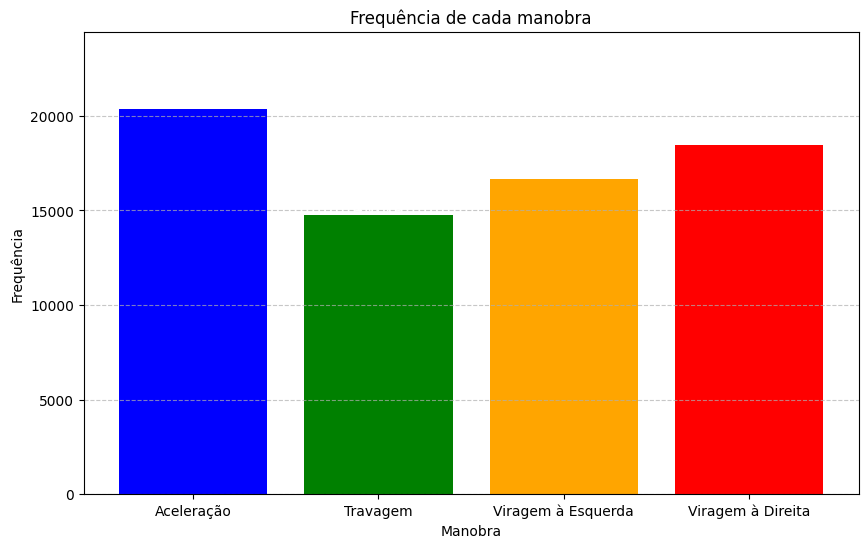

In [30]:

def count_manobras(accelY, breakY, turnLeftXn, turnRightXn):
    manobras = {
        'Aceleração': np.count_nonzero(accelY),
        'Travagem': np.count_nonzero(breakY),
        'Viragem à Esquerda': np.count_nonzero(turnLeftXn),
        'Viragem à Direita': np.count_nonzero(turnRightXn)
    }
    
    return manobras

#calcula a disntancia entre dois pontos
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # +- raio da terra em metros
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

#distancia total percorrida
def total_distance(lat, lon):
    distance = 0.0
    for i in range(1, len(lat)):
        distance += haversine(lat[i], lon[i], lat[i - 1], lon[i - 1])
    return distance


#print distance total percorrida em km arrendondado a 2 casas decimais
print(f'Distância total percorrida: {total_distance(latitude, longitude) / 1000:.2f} km')

#print numero total de leituras de manobras
print(f'Numero Total de Manobras: {count_manobras(accelY, breakY, turnLeftXn, turnRightXn)} manobras')




manobras = count_manobras(accelY, breakY, turnLeftXn, turnRightXn)

manobras_labels = list(manobras.keys())
manobras_quantidades = list(manobras.values())


cores = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
bars = plt.bar(manobras_labels, manobras_quantidades, color=cores)

for bar, quantidade in zip(bars, manobras_quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, quantidade,
             ha='center', va='bottom', color='white', fontsize=12)

plt.xlabel('Manobra')
plt.ylabel('Frequência')
plt.title('Frequência de cada manobra')
plt.ylim(0, max(manobras_quantidades) * 1.2)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Show manovers on Google Map

In [31]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

## Plot manovers

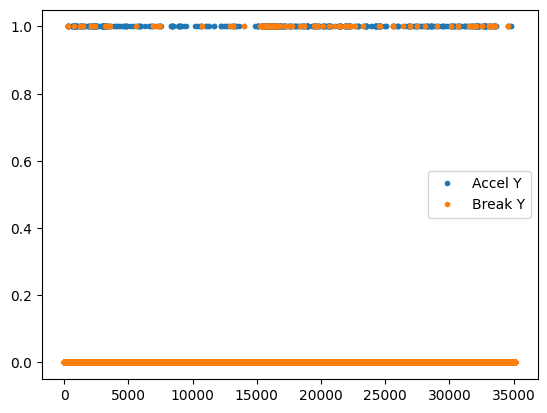

In [32]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# Split Dataset for Model Training

This section splits the dataset into training, test, and validation sets

- 75% Training
- 25% Test

Stratify ensures each set maintains the original class distribution.

In [33]:
# x_train, x_test = split_train_test(x, test_size=0.2)

# y_train, y_test = split_train_test(y, test_size=0.2)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(26346, 12) (26346, 12)
(8783, 12) (8783, 12)


## Create input tensor data

In [34]:
train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

print(train.shape)
print(test.shape)

np.savetxt("runtime_saves/train&test/x_train.csv", x_train, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/x_test.csv", x_test, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/y_train.csv", y_train, delimiter=',', fmt='%.0i')
np.savetxt("runtime_saves/train&test/y_test.csv", y_test, delimiter=',', fmt='%.0i')

np.savetxt("runtime_saves/train&test/train.csv", train.reshape(train.shape[0], train.shape[2]), delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/test.csv", test.reshape(test.shape[0], test.shape[2]), delimiter=',', fmt='%.9f')

(26346, 1, 12)
(8783, 1, 12)


# **MODEL ARCHITECTURE** - Conv LSTM

 **Camada Bidirectional**
   - **Tipo:** Bidirectional
   - **Filtros:** 64
   - **Formato de Entrada:** `(train.shape[1], train.shape[2])`

**Camada BatchNormalization**

**Camada Dropout (0.5)**
  - **Taxa de Dropout:** 50%
  

**Camada Bidirectional**
  - **Tipo:** Bidirectional
  - **Filtros:** 64

   
**Camada BatchNormalization**

**Camada Dropout (0.2)**
  - **Taxa de Dropout:** 20%
 

**Camada Dense**
  - **Tipo:** Dense
  - **Filtros:** 64
  - **Ativação:** ReLU
    

**Camada BatchNormalization**
  
**Camada Dropout (0.3)**
  - **Taxa de Dropout:** 30%
   

**Camada Dense**
  - **Tipo:** Dense
  - **Filtros:** 12
  - **Ativação:** Sigmoid

In [35]:
# Clear session
K.clear_session()

# Model configuration
dropout1 = 0.5
dropout2 = 0.2
dropout3 = 0.1
initial_learning_rate = 0.001

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train.shape[1], train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(dropout1))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(dropout2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout3))

model.add(Dense(12, activation='sigmoid'))

## Compile Model

**Loss function:** \
Use the *Binary Crossentropy* loss function because it is a `binary multi-class classification` problem.

**Optimizer:** \
Exploring the *Adam* optimizer.

**Metrics:** \
The *accuracy* metric is used to evaluate the model.

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

## Train Model

- 30 epochs
- Batch size of 64
- Early stopping
- Learning rate reduction on plateau
- Model checkpoint

In [36]:
# best callback for the model
best_model_file = 'runtime_saves/models/BiLSTM/model.keras'
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
history = model.fit(train, y_train, epochs=30, batch_size=256 , validation_data=(test, y_test), verbose=1, callbacks=[best_model, early_stop])


Epoch 1/30
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1002 - loss: 0.7271
Epoch 1: val_loss improved from inf to 0.41544, saving model to runtime_saves/models/BiLSTM/model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.1008 - loss: 0.7241 - val_accuracy: 0.0034 - val_loss: 0.4154
Epoch 2/30
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1306 - loss: 0.3144
Epoch 2: val_loss improved from 0.41544 to 0.13043, saving model to runtime_saves/models/BiLSTM/model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1306 - loss: 0.3128 - val_accuracy: 0.0034 - val_loss: 0.1304
Epoch 3/30
100/103 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1521 - loss: 0.0894
Epoch 3: val_loss improved from 0.13043 to 0.08918, saving model to runtime_saves/models/BiLSTM/model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1523 - loss: 0.0888 - val_accuracy: 0.0051 - val_loss: 0.0892
Epoch 4/30
 99/103 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0

## Save Model

In [ ]:
model.save('runtime_saves/models/1A-BidirecionalLSTM.h5')

## Load Model

In [ ]:
from keras.models import load_model

model = load_model('runtime_saves/models/1A-BidirecionalLSTM.h5')

# **RESULTS AND EVALUATION**

## Performance Metrics

- Accuracy  $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  
- F1 Score $\large = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$  
- Hamming Loss $\large = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Incorrect Labels}}{\text{Total Labels}}$  
- Jaccard Score $\large = \frac{|Y_{pred} \cap Y_{true}|}{|Y_{pred} \cup Y_{true}|}$  



- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [37]:
y_pred = model.predict(test)

y_pred = np.round(y_pred)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss', 'Jaccard Score'],
    'Value': [
        accuracy_score(y_test, y_pred) * 100,
        precision_score(y_test, y_pred, average="weighted") * 100,
        recall_score(y_test, y_pred, average="weighted") * 100,
        f1_score(y_test, y_pred, average="weighted") * 100,
        hamming_loss(y_test, y_pred) * 100,
        jaccard_score(y_test, y_pred, average="weighted") * 100,
    ]
}

# Crie o DataFrame
metrics_df = pd.DataFrame(metrics)

# Formate os valores como percentagem
metrics_df['Value'] = metrics_df['Value'].map('{:.2f}%'.format)

# Exiba o DataFrame
metrics_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Metric,Value
0,Accuracy,97.64%
1,Precision,95.06%
2,Recall,92.96%
3,F1 Score,93.76%
4,Hamming Loss,0.20%
5,Jaccard Score,88.74%


## Confusion Matrix

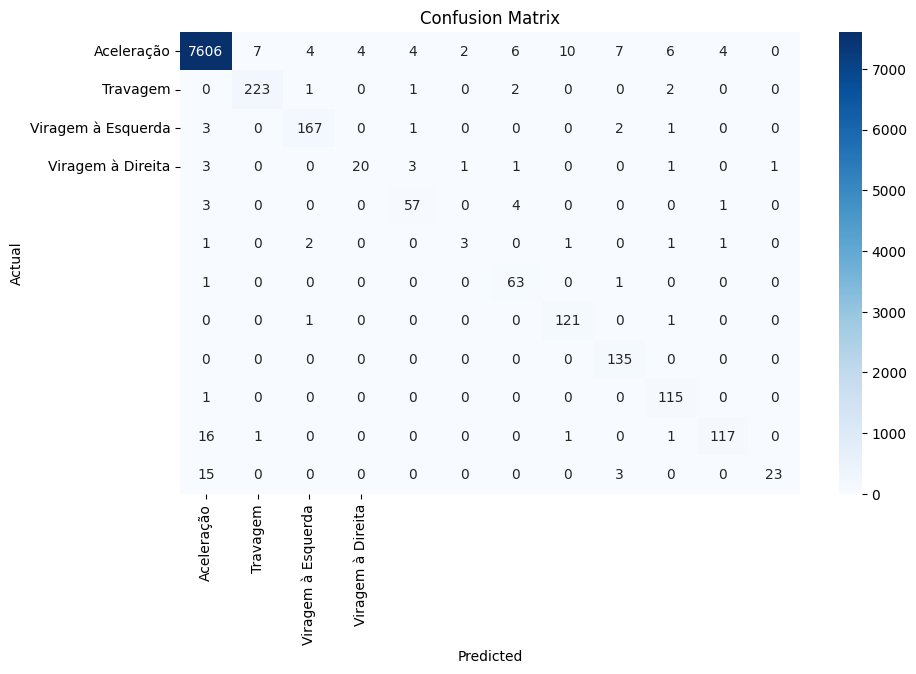

In [38]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=manobras_labels, yticklabels=manobras_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **TEST THE NETWORK**

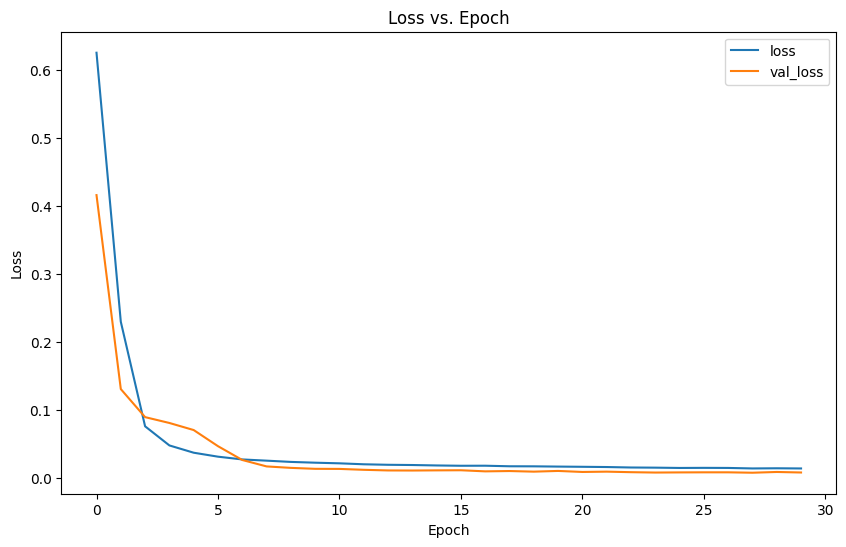

In [39]:
#plot loss e val_loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sample 12:
X: [0.2 0.  0.1 0.  0.  0.1 0.  0.1 0.2 0.  0.  0. ]
Y: [1 0 0 0 0 0 0 0 0 0 0 0]
Predicted Class: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------------------------------


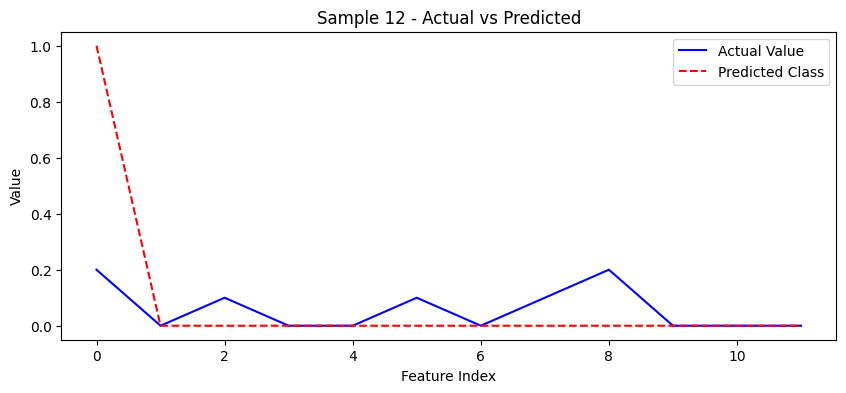

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sample 14:
X: [0.2 0.  0.1 0.  0.  0.  0.  0.1 0.  0.6 0.  0. ]
Y: [0 0 0 0 0 0 0 0 0 1 1 0]
Predicted Class: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]
------------------------------


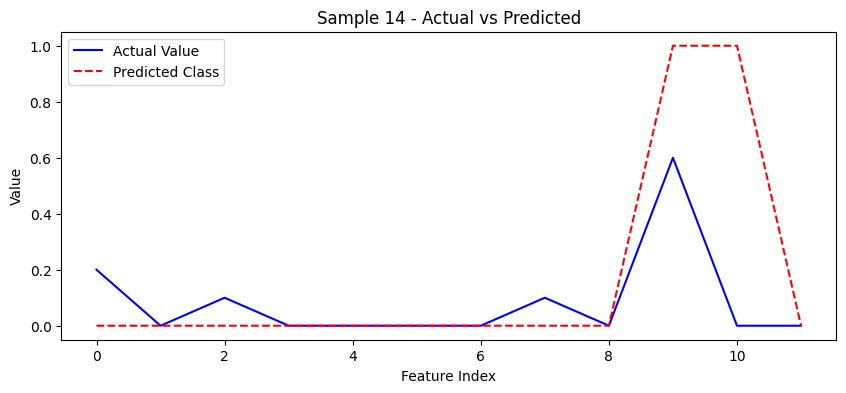

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sample 15:
X: [0.  0.1 0.  0.  0.  0.  0.1 0.  0.3 0.  0.  0. ]
Y: [0 0 0 0 0 0 0 0 1 0 0 0]
Predicted Class: [[0.  0.1 0.  0.  0.  0.  0.  0.  0.7 0.  0.  0. ]]
------------------------------


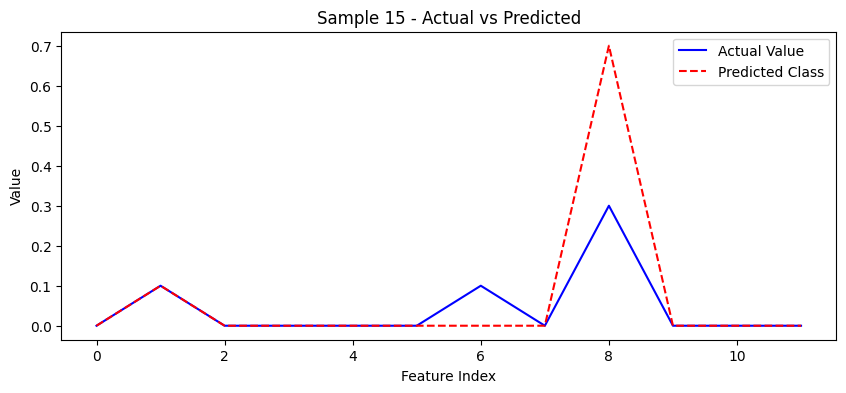

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sample 23:
X: [0.  0.2 0.1 0.  0.  0.2 0.1 0.  0.  0.2 0.  0. ]
Y: [0 1 0 0 0 0 0 0 0 0 0 0]
Predicted Class: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------------------------------


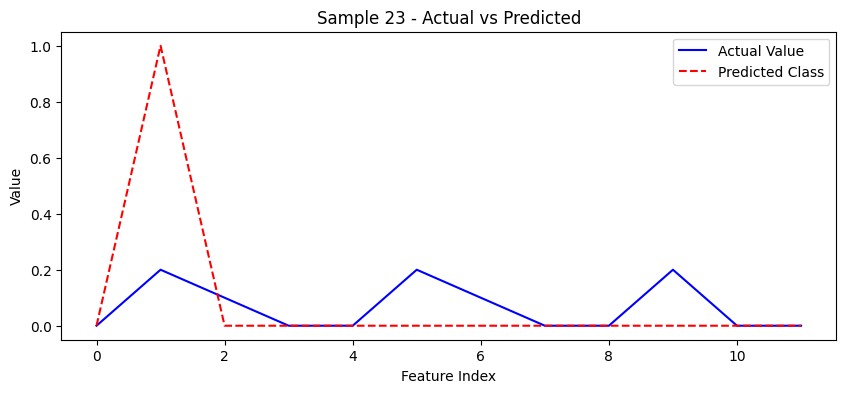

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sample 28:
X: [0.  0.  0.2 0.  0.  0.1 0.1 0.  0.  0.2 0.  0. ]
Y: [0 0 1 0 0 0 0 0 0 0 0 0]
Predicted Class: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------------------------------


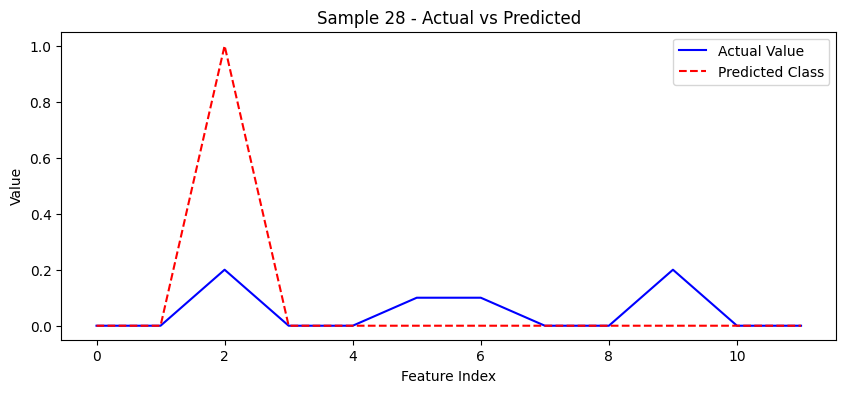

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sample 29:
X: [0.  0.  0.2 0.  0.  0.2 0.  0.1 0.1 0.  0.  0. ]
Y: [0 0 1 0 0 0 0 0 0 0 0 0]
Predicted Class: [[0.  0.  0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
------------------------------


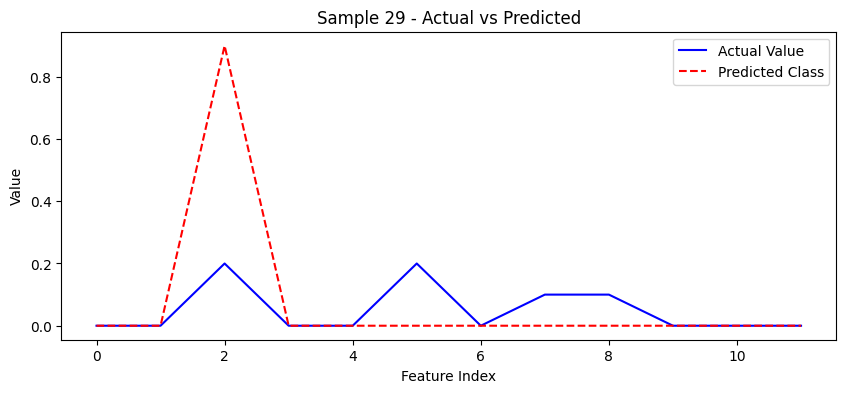

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 43:
X: [0.2 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0. ]
Y: [1 0 0 0 0 0 0 0 0 0 0 0]
Predicted Class: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------------------------------


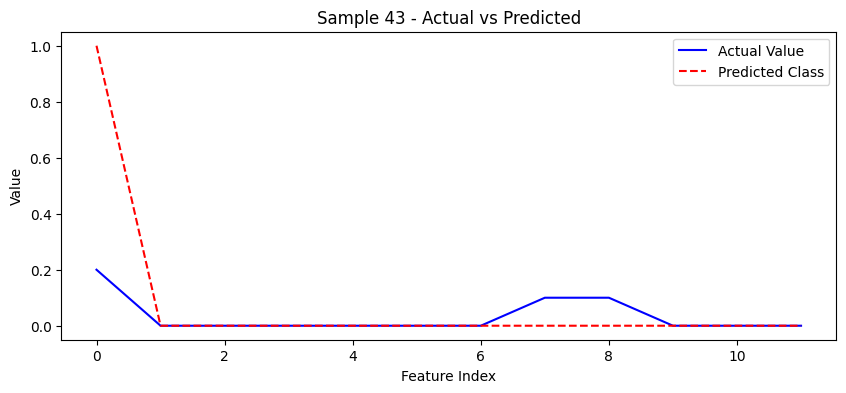

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample 44:
X: [0.3 0.  0.  0.  0.2 0.  0.1 0.  0.1 0.  0.  0. ]
Y: [1 0 0 0 0 0 0 0 0 0 0 0]
Predicted Class: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------------------------------


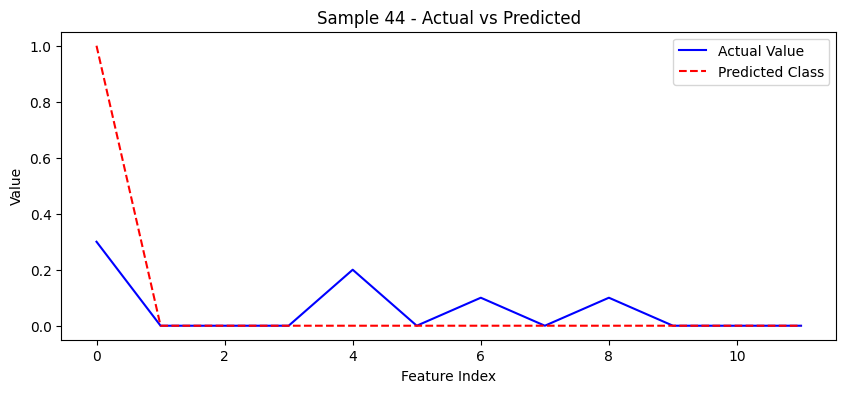

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sample 49:
X: [0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.3 0.  0. ]
Y: [0 1 0 0 0 0 0 0 0 1 0 0]
Predicted Class: [[0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.4 0.3 0. ]]
------------------------------


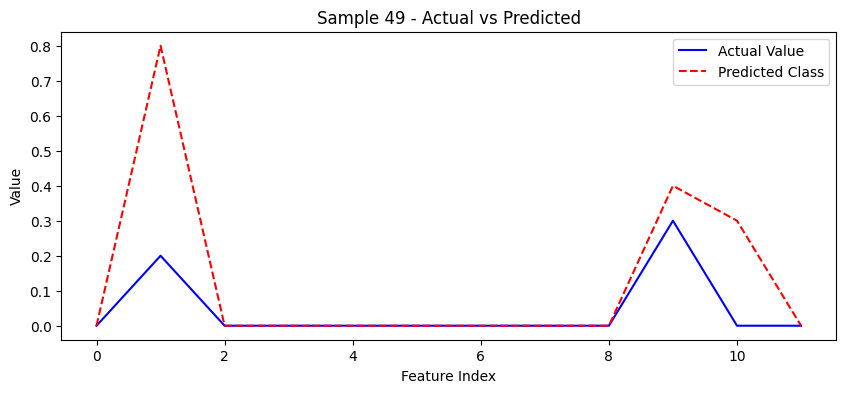

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sample 64:
X: [0.  0.  0.  0.2 0.4 0.  0.2 0.  0.2 0.  0.  0. ]
Y: [0 0 0 0 1 0 0 0 0 0 0 0]
Predicted Class: [[0.  0.  0.  0.1 1.  0.  0.1 0.  0.  0.  0.  0. ]]
------------------------------


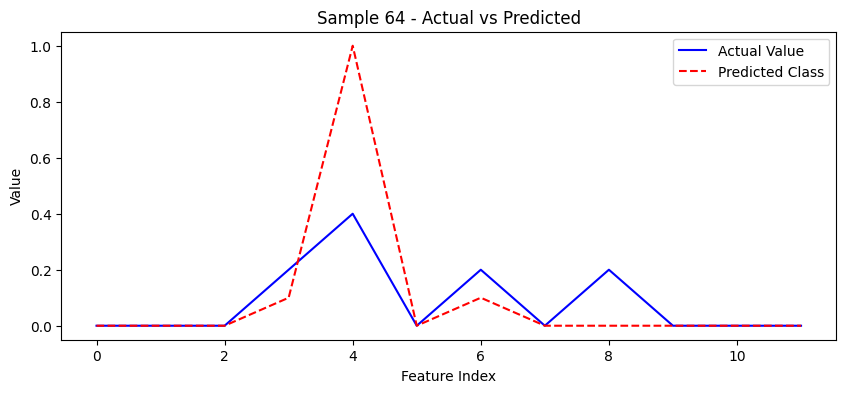

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sample 75:
X: [0.1 0.  0.1 0.  0.2 0.  0.  0.1 0.  0.3 0.  0. ]
Y: [0 0 0 0 0 0 0 0 0 0 1 0]
Predicted Class: [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.  0. ]]
------------------------------


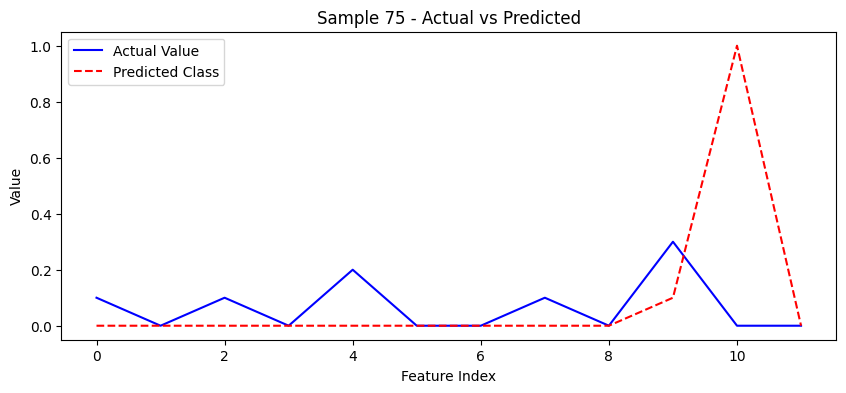

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sample 82:
X: [0.1 0.  0.1 0.  0.  0.  0.  0.  0.  0.3 0.  0. ]
Y: [0 0 0 0 0 0 0 0 0 1 0 0]
Predicted Class: [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.  0. ]]
------------------------------


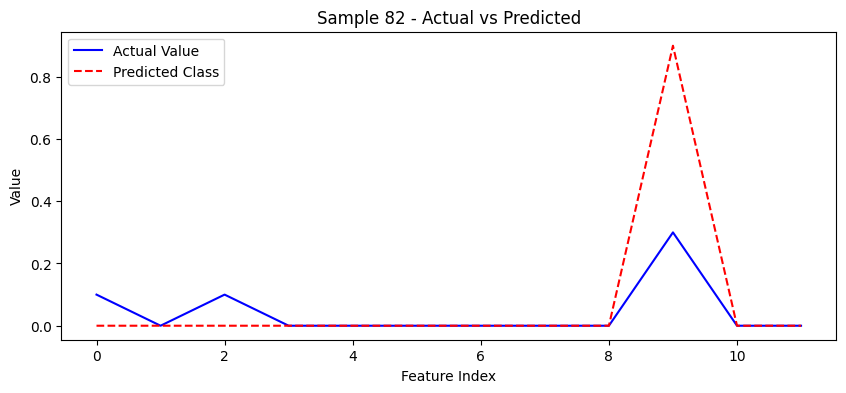

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sample 90:
X: [0.  0.1 0.  0.  0.  0.1 0.  0.  0.  0.1 0.  0. ]
Y: [0 0 0 0 0 0 0 0 0 0 1 0]
Predicted Class: [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0. ]]
------------------------------


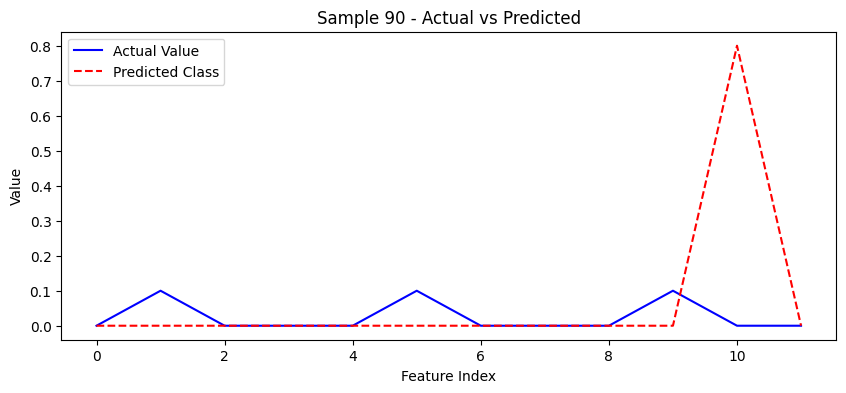

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 92:
X: [0.1 0.  0.2 0.  0.  0.1 0.  0.1 0.  0.1 0.  0. ]
Y: [0 0 1 0 0 0 0 0 0 0 0 0]
Predicted Class: [[0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
------------------------------


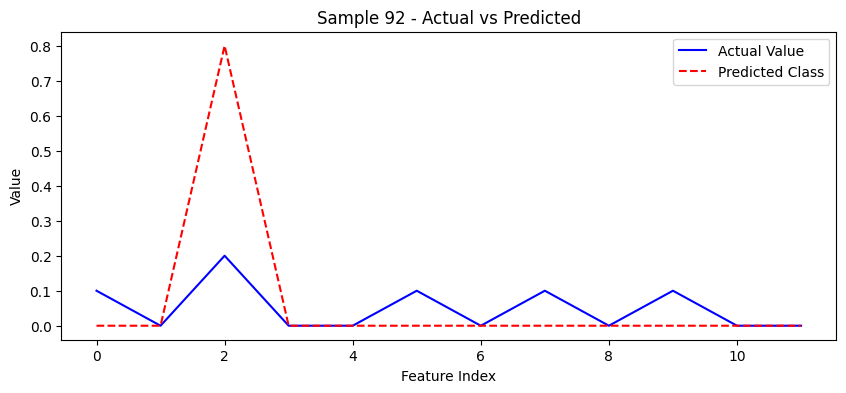

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 94:
X: [0.  0.  0.  0.2 0.2 0.  0.2 0.  0.  0.  0.  0. ]
Y: [0 0 0 0 0 0 1 0 0 0 0 0]
Predicted Class: [[0.  0.  0.  0.  0.2 0.  0.5 0.  0.  0.  0.  0. ]]
------------------------------


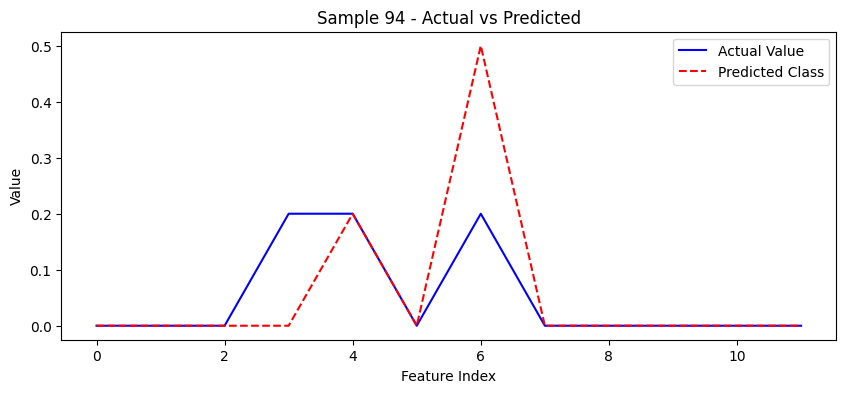

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sample 95:
X: [0.1 0.  0.4 0.  0.  0.4 0.  0.2 0.  0.1 0.  0. ]
Y: [0 0 1 0 0 1 0 0 0 0 0 0]
Predicted Class: [[0.  0.  1.  0.  0.  0.7 0.  0.  0.  0.  0.  0. ]]
------------------------------


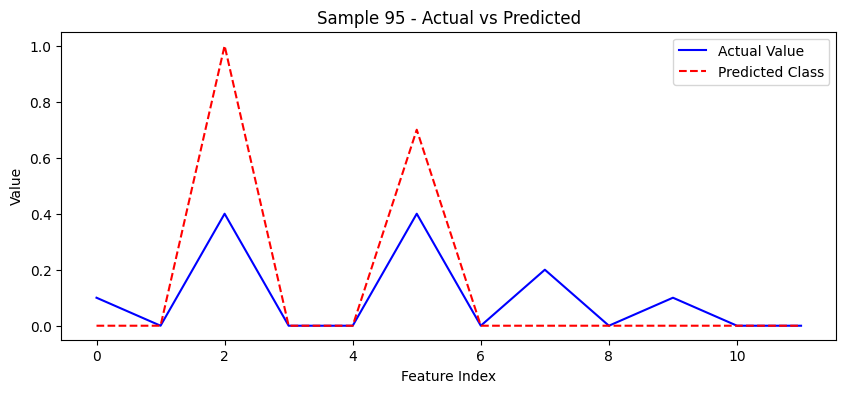

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [40]:

def visualize_predictions(x_test, y_test, model, num_samples=100):
    for i in range(num_samples):
        a = x_test[i]
        b = a.reshape(1, 1, 12)

        prediction = model.predict(b)
        predicted_class = np.round(prediction, decimals=1)

        actual_values = np.round(x_test[i], decimals=1)
        true_class = np.round(y_test[i], decimals=1)

        if np.sum(y_test[i]) > 0:
            print(f"Sample {i+1}:")
            print(f"X: {actual_values}")
            print(f"Y: {true_class}")
            print(f"Predicted Class: {predicted_class}")
            print("-" * 30)

            fig, ax = plt.subplots(figsize=(10, 4))

            ax.plot(range(12), actual_values, 'b', label='Actual Value')

            ax.plot(range(12), predicted_class.flatten(), 'r--', label='Predicted Class')

            ax.set_xlabel('Feature Index')
            ax.set_ylabel('Value')
            ax.set_title(f'Sample {i+1} - Actual vs Predicted')
            ax.legend()
            plt.show()

visualize_predictions(x_test, y_test, model, num_samples=100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Value    : [0.    0.363 0.313 0.    0.    0.31  0.393 0.    0.    0.244 0.247 0.   ]
Predicted: [0.   0.9  0.99 0.   0.01 0.   0.76 0.   0.01 0.   1.   0.  ]


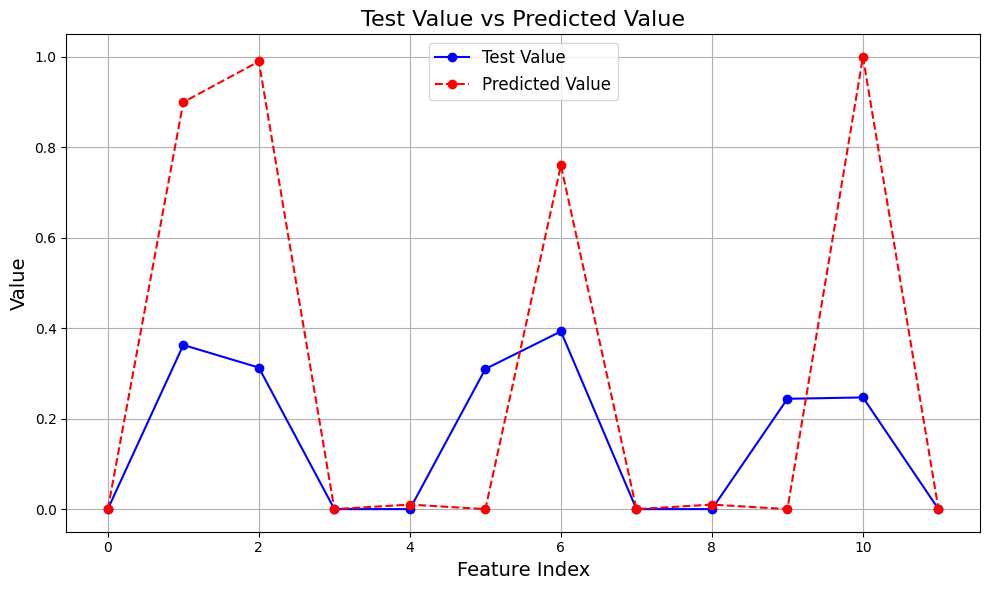

In [41]:
import numpy as np
import matplotlib.pyplot as plt


test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

prediction = model.predict(test_value)
prediction = prediction.flatten()  
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(12), test_value[0][0], 'bo-', label='Test Value')

ax.plot(range(12), prediction, 'ro--', label='Predicted Value')

ax.set_xlabel('Feature Index', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('Test Value vs Predicted Value', fontsize=16)
ax.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()


# **TESTE**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


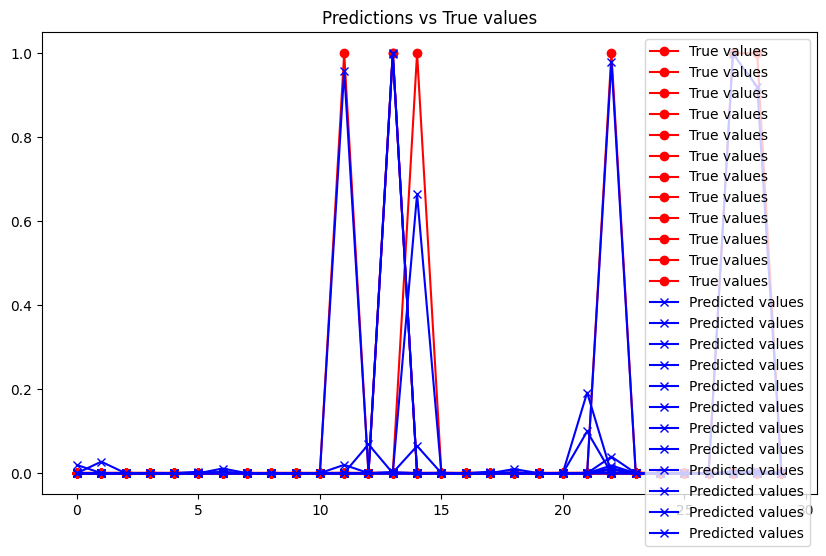

In [42]:
def test_model(model, test_data, test_labels, start, end):
    predictions = model.predict(test_data[start:end])

    plt.figure(figsize=(10, 6))
    plt.plot(test_labels[start:end], 'ro-', label='True values')
    plt.plot(predictions, 'bx-', label='Predicted values')
    plt.title('Predictions vs True values')
    plt.legend()
    plt.show()
    
    return predictions

predictions = test_model(model, test, y_test, 0, 30)
